# <center> News classification with ULMFiT. Starter

Here we mostly follow the training scheme described by Jeremy Howard in [fast.ai Lesson 4](https://course.fast.ai/videos/?lesson=4): taking a pretrained language model, fine-tuning it with unlabeled data, then fine-tuning classification head for our particular task.

This is just a starter. At each step, I also mention how you can do better.

In [31]:
from tqdm import tqdm_notebook
import torch
import fastai
from fastai.text import *
fastai.__version__

'1.0.51'

- Train on label and text

# Preprocessing
Here we write all news texts from train, validation and text files into `unlabeled_news.csv` - to train a language model.

Then, we write texts and labels into `train_28k.csv` and texts only into `test_5k.csv`.

**How to do better:** go for that 80k unlabeled set as well.

In [38]:
train = pd.read_csv('./train.csv').fillna(' ')
valid = pd.read_csv('./valid.csv').fillna(' ')
test = pd.read_csv('./test.csv').fillna(' ')

In [39]:
unlabeled = pd.read_csv("./unlabeled.csv").fillna(' ')

In [40]:
unlabeled.to_csv('unlabeled_news.csv', index=None, header=True)

In [3]:
# pd.concat([train['text'], valid['text'], test['text']]).to_csv('unlabeled_news.csv', index=None, header=True)

# TODO add unlabeled data

In [41]:
pd.concat([train[['text', 'label']],valid[['text', 'label']]]).to_csv('train_28k.csv', index=None, header=True)
test[['text']].to_csv('test_5k.csv', index=None, header=True)

In [42]:
folder = '.'
unlabeled_file = 'unlabeled_news.csv'

# Reading unlabeled data to train ULMFiT language model

In [43]:
data_lm = TextLMDataBunch.from_csv(folder, unlabeled_file, text_cols='text')

# LM training 

Here we resort to the training scheme described by Jeremy Howard, [fast.ai](https://course.fast.ai/):
 - finding good initial learning rate
 - training for one epoch
 - unfreezing and more training

**How to do better:** train for 10-15 epochs after unfreezing

In [45]:
learn = language_model_learner(data_lm, drop_mult=0.3, arch=AWD_LSTM, pretrained=True)

In [46]:
learn.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.16E-02


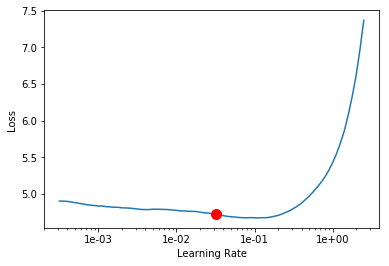

In [47]:
learn.recorder.plot(skip_end=10, suggestion=True)

In [48]:
best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

0.031622776601683784

In [ ]:
learn.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save_encoder('clickbait_news_enc_pretrained_unlabeled')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time


# Generating some text

It's always interesting to see whether a LM is able to generate nice text. With LM training improvement (in terms of loss), at some point you'll notice some nice improvement in quality of the generated text.

One sample generated with my better-trained LM:

> 'An italian man was found dead in his yard due to heat conditions on Sunday night , his spokeswoman said . The office manager of the Ultra retired man ’s office told buzzfeed News there being no sign of comfort . The man at his 911 home told guy , he had been in contact with his car ’s owner before asleep and then immediately responded to starting fire . The man named Guy made a news video at PARKING Station in which the Mississippi State Police shot multiple people with Tim Shepherd to get their son alive , Mark Morris , a family friend dangling near his wife ’s house , said . The teen told police he was winning inclusion in general . Police dragged him into the house — where the officer had been yards away — during his die - hard bid at a nearby snow salon . The family voted in favor of Appreciative and arrested more than three months later : They tried to detained him . He and his family stopped , per the station , all the way up . “'

No much sense, but at least some structure :) And now with GPT-2 we see that quantitative improvements can also lead to qualital improvements.

In [33]:
learn.predict('An italian man was found dead in his yard due to', n_words=200)

'An italian man was found dead in his yard due to picked money . He had been laid off by an unknown British on ncaa charges students accused calling him the " Cincinnati man " after he struck a devastation on a pair of dealing picks in spring 2015 . In a statement , Ohio State star U. S. Ned Ultrasound explained that Columbia tried to force B. 1976 into playing football with him as a baggage unqualified . " There are kinds of other words that are washing out required . Others are point - blank or any matter where they win . They \'re very rare . Maybe we \'ve found a authorities governor that \'s been fishing in the open . Per my giant ambitions , he stands out so much people people encourage me and those people who came back and were not feeling like they were bad do n\'t , but they would n\'t quit if they did . " That , and for now , my cases are against each other , " added Dr. Pierre Wavelengths of the University of Wisconsin'

In [34]:
learn.save_encoder('clickbait_news_enc')

# Training classification head

Here again we follow Jeremy Howard. 

**How to do better:** hyperparam tuning (though it's extremely annoying with such a heavy model), more epochs after unfreezing, check for some live examples of ULMFiT training, different learning rates for different layers etc.

In [9]:
train_file, test_file = 'train_28k.csv', 'test_5k.csv'

In [10]:
data_clas = TextClasDataBunch.from_csv(path=folder, 
                                        csv_name=train_file,
                                        test=test_file,
                                        vocab=data_lm.train_ds.vocab, 
                                        bs=64,
                                        text_cols='text', 
                                        label_cols='label')

In [11]:
data_clas.save('ulmfit_data_clas_clickbait_news')

In [12]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.3, arch=AWD_LSTM)  
learn_clas.load_encoder('clickbait_news_enc')

In [ ]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))

In [ ]:
learn_clas.recorder.plot(skip_end=10, suggestion=True)

In [45]:
best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

0.0006309573444801934

In [13]:
best_clf_lr = 0.0006309573444801934

In [14]:
learn_clas.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.637953,0.466568,0.848549,1:53:01


In [16]:
learn_clas.save("clickbait_news_model")

In [17]:
learn_clas.freeze_to(-2)

In [18]:
learn_clas.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.561503,0.375262,0.860334,2:15:01


In [19]:
learn_clas.save("clickbait_news_model")

In [20]:
learn_clas.unfreeze()

In [ ]:
learn_clas.fit_one_cycle(1, best_clf_lr)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn_clas.show_results()

In [25]:
learn_clas.save("clickbait_news_model")

# Predictions for the test set

I'm doing it very inefficiently - one instance at a time

**How to do better:** in a mini-batch manner. 

In [26]:
test_preds = np.concatenate([learn_clas.predict(item=test.iloc[i])[2].cpu().numpy().reshape(1, -1)
                            for i in tqdm_notebook(range(len(test)))], axis=0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Forming a submission file

In [27]:
test_pred_df = pd.DataFrame(test_preds, columns=['clickbait', 'news', 'other'])
ulmfit_preds = pd.Series(np.argmax(test_pred_df.values, axis=1),
                        name='label').map({0: 'clickbait', 1: 'news', 2: 'other'})


In [28]:
ulmfit_preds.head()

0         news
1    clickbait
2         news
3         news
4         news
Name: label, dtype: object

In [29]:
ulmfit_preds.to_csv('ulmfit_predictions.csv', index_label='id', header=True)